# Given a field, here we detect the defects

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf
!pip install pydot
from tensorflow.keras.utils import plot_model
import pydot
from tensorflow.keras.models import Model

# Implementation for calculating the topological charge estimator 

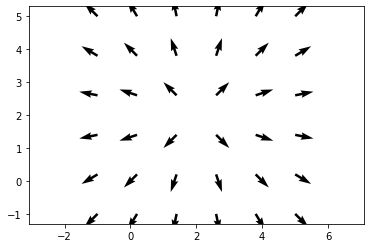

In [3]:
'Getting the angle from the given vector fields'

def theta(vx,vy):
    n=vx.shape[0]
    theta=np.zeros((n,n))
    
    for i in range (n):
        for j in range (n):
            
            theta[i][j]=(math.asin(vy[i][j]/(vx[i][j]**2 + vy[i][j]**2)**0.5))
            
            if(vx[i][j]<0 and vy[i][j] >=0):#2nd quadrant
                theta[i][j]=np.pi-theta[i][j]
                
            elif(vx[i][j]<0 and vy[i][j]<=0):#3rd quadrant
                theta[i][j]=np.pi+abs(theta[i][j])
                
            elif(vx[i][j]>=0 and vy[i][j]<0):#4th quadrant
                theta[i][j]=2*np.pi-abs(theta[i][j])
                
    return theta

'Getting the mod of 2pi needed for our charge calculations'
def mod(theta):
    
    if(theta<-np.pi):
        theta+=2*np.pi
    elif(theta>np.pi):
        theta-=np.pi*2
    elif(theta==-np.pi or theta==np.pi):
        theta=np.pi
    return theta

'getting the charge estimate'
def tce(theta):
    tce=np.zeros((theta.shape[0]-1,theta.shape[0]-1))
    for i in range (theta.shape[0]-1):
        for j in range(theta.shape[0]-1):
            tce[i][j]=mod(theta[i+1][j]-theta[i][j])+mod(theta[i+1][j+1]-theta[i+1][j])+mod(theta[i][j+1]-theta[i+1][j+1])+mod(theta[i][j]-theta[i][j+1])
            tce[i][j]=tce[i][j]/(np.pi*2)
            tce[i][j]=round(tce[i][j])*1
    return tce


'Define the function that calculates the electric field'

def electric_field(x, y, q1=1, q2=0):
    r1 = np.sqrt((x-2)**2 + (y-2)**2)
    r2 = np.sqrt((x - 3)**2 + (y - 3)**2)

    r1_hat_x = (x -2)/ r1
    r1_hat_y = (y-2) / r1
    r2_hat_x = (x - 3) / r2
    r2_hat_y = (y -3) / r2
    
    E1_x = q1 / r1**2 * r1_hat_x
    E1_y = q1 / r1**2 * r1_hat_y
    E2_x = q2 / r2**2 * r2_hat_x
    E2_y = q2 / r2**2 * r2_hat_y
    
    E_x = E1_x + E2_x
    E_y = E1_y + E2_y
    return E_x, E_y

# Define the grid size
N = 6

# Define the coordinates of the grid points
x = np.linspace(-1, 5, N)
y = np.linspace(-1, 5, N)

# Evaluate the electric field at the grid points
nx, ny = np.meshgrid(x, y, indexing='ij')
vx, vy = electric_field(nx, ny)
u=(vx**2+vy**2)**0.5
vx=vx/u
vy=vy/u

# Plot the vector field
plt.quiver(nx, ny, vx, vy)
plt.axis('equal')
plt.show()

# Here given a vector field vx,vy we obtain the topological charge matrix

In [6]:
t=tce(theta(vx,vy))
t

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

# Here, we try to do the inverse, given a charge matrix, can we obtain the corresponding fields vx,vy?

The model takes the coordinats as input (in this reduced version its not really required but once we include the PDEs it is required) and give out fields as the output, we then calculate the charges from these fields and use that with the real charges in the loss function.

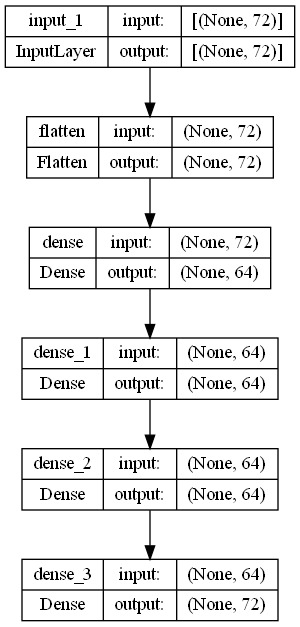

In [8]:
def mmodel():
    input_layer=tf.keras.Input(shape=(72))
    
    flatten_layer = tf.keras.layers.Flatten()(input_layer)
    first_dense = tf.keras.layers.Dense(64, activation=tf.nn.relu)(flatten_layer)
    second_dense= tf.keras.layers.Dense(64, activation=tf.nn.relu)(first_dense)
    third_dense= tf.keras.layers.Dense(64, activation=tf.nn.relu)(second_dense)
    output_layer = tf.keras.layers.Dense(72, activation='sigmoid')(third_dense)
    
    func_model = Model(inputs=input_layer, outputs=output_layer)
    
    return func_model

def my_loss(t_true,y_pred):
    
    y1,y2 = tf.split(y_pred, num_or_size_splits=2, axis=1)
    ex=tf.reshape(y1,[6,6])
    ey=tf.reshape(y2,[6,6])
    
    t_pred=tce(theta(ex,ey))
    t_pred=tf.reshape(t_pred,[1,25])
    loss=tf.reduce_sum(tf.square(t_pred - t_true))
    
    return loss

model = mmodel()
# Plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')


In [9]:
uux=tf.convert_to_tensor(vx, dtype=tf.float32, dtype_hint=None, name=None)
uuy=tf.convert_to_tensor(vy, dtype=tf.float32, dtype_hint=None, name=None)
X=np.concatenate((nx,ny))
X=np.reshape(X,(1,72))
X=tf.convert_to_tensor(X, dtype=tf.float32, dtype_hint=None, name=None)
t=tce(theta(uux,uuy))
t=tf.reshape(t,[1,25])
model=mmodel()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer='sgd', loss=my_loss)
#model.fit(X,t,epochs=20)

In [11]:
model.fit(X,t,epochs=20)

Epoch 1/20
1/1 [==============================] - 0s 157ms/step - loss: 1.0000
Epoch 2/20
1/1 [==============================] - 0s 56ms/step - loss: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 44ms/step - loss: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 46ms/step - loss: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 41ms/step - loss: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 65ms/step - loss: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 57ms/step - loss: 1.0000
Epoch 8/20
1/1 [==============================] - 0s 70ms/step - loss: 1.0000
Epoch 9/20
1/1 [==============================] - 0s 43ms/step - loss: 1.0000
Epoch 10/20
1/1 [==============================] - 0s 40ms/step - loss: 1.0000
Epoch 11/20
1/1 [==============================] - 0s 35ms/step - loss: 1.0000
Epoch 12/20
1/1 [==============================] - 0s 41ms/step - loss: 1.0000
Epoch 13/20
1/1 [==============================] - 0s 57ms/s

As we can see, the loss is not decresing at all. The reason for this is mentioned in the report 

In [13]:
y_pred=model.predict(X)

y1,y2 = tf.split(y_pred, num_or_size_splits=2, axis=1)
ex=tf.reshape(y1,[N,N])
ey=tf.reshape(y2,[N,N])
u=ex**2+ey**2
u=u**0.5
ex=ex/u
ey=ey/u

1/1 [==============================] - 0s 38ms/step


# Plotting the predicted field

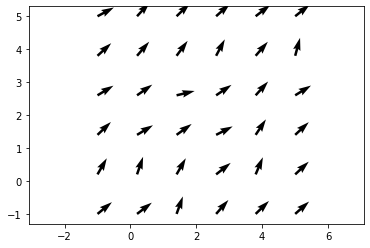

In [14]:
 # Plot the vector field
plt.quiver(nx, ny, ex, ey)
plt.axis('equal')
plt.show() 